# Definitive GNN+NDS Benchmark: Feature Augmentation Methods for Graph Classification

This notebook demonstrates a benchmark comparing **Nonlinear Diffusion Signatures (NDS)** against other feature augmentation methods for graph classification. The benchmark uses:

- **Graph-level feature pooling + SVM** for fast CPU-based evaluation
- **GIN (Graph Isomorphism Network)** validation on MUTAG
- **Rook/Shrikhande verification** to test 1-WL breaking capability
- **SIGN == linear trajectory** sanity check

**Methods compared:** vanilla, degree, NDS-tanh (deg+clust init), NDS-tanh (LapPE init), SIGN-T, LapPE, RWSE, RNI, NDS-sin, linear trajectory.

**Dataset:** MUTAG (graph classification, 2 classes, 10-fold CV)

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# torch-geometric — NOT on Colab, always install
_pip('torch-geometric')

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'scikit-learn==1.6.1', 'matplotlib==3.10.0')
    _pip('torch==2.9.0+cpu', '--index-url', 'https://download.pytorch.org/whl/cpu')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import itertools
import time
from copy import deepcopy
from pathlib import Path

import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import scipy.sparse.csgraph
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import degree
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## Data Loading

Load the MUTAG graph classification dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/experiment_iter6_definitive_gnn/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data["datasets"]:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 1 dataset(s)
  MUTAG: 60 examples


## Configuration

All tunable parameters are defined here. Start with minimum values for quick testing; increase for better results.

In [5]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = torch.device("cpu")

# Dataset and method selection
DATASET_NAMES = ["MUTAG"]
METHOD_NAMES = [
    "vanilla",
    "degree",
    "nds_tanh_degclust",
    "nds_tanh_lappe",
    "sign_t10",
    "lappe_k8",
    "rwse_k16",
    "rni_d8",
    "nds_sin_degclust",
    "linear_traj",
]

# GIN hyperparameters (for MUTAG validation only)
# Original: GIN_HIDDEN=32, GIN_LAYERS=3, GIN_EPOCHS=15, GIN_PATIENCE=8
GIN_HIDDEN = 32
GIN_LAYERS = 3
GIN_EPOCHS = 15
GIN_PATIENCE = 8
GIN_BATCH = 256
GIN_LR = 0.01
GIN_DROPOUT = 0.5

# Feature preprocessing
# Original: NDS_T=10, LAPPE_K=8, RWSE_K=16, RNI_D=8
NDS_T = 10
LAPPE_K = 8
RWSE_K = 16
RNI_D = 8

# SVM parameters for main benchmark
SVM_C_VALUES = [0.1, 1.0, 10.0]

print("Configuration loaded.")

Configuration loaded.


## Phase 1 — Data Parsing

Parse JSON data into PyTorch Geometric `Data` objects.

In [6]:
def load_graphs_from_data(raw: dict) -> dict:
    """Parse loaded JSON into PyG Data objects."""
    all_datasets = {}
    for ds_entry in raw["datasets"]:
        ds_name = ds_entry["dataset"]
        if ds_name not in DATASET_NAMES:
            continue
        graphs = []
        for ex in ds_entry["examples"]:
            graph_info = json.loads(ex["input"])
            edge_list = graph_info["edge_list"]
            num_nodes = graph_info["num_nodes"]
            node_feats = graph_info.get("node_features", None)

            if edge_list:
                edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
            else:
                edge_index = torch.zeros((2, 0), dtype=torch.long)

            if node_feats is not None and len(node_feats) > 0:
                x = torch.tensor(node_feats, dtype=torch.float)
            else:
                x = torch.ones((num_nodes, 1), dtype=torch.float)

            y = int(ex["output"])
            fold = int(ex["metadata_fold"])
            d = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
            d.fold = fold
            d._raw_input = ex["input"]
            d._raw_output = ex["output"]
            d._raw_meta = {k: v for k, v in ex.items() if k.startswith("metadata_")}
            graphs.append(d)
        all_datasets[ds_name] = graphs
        print(
            f"  {ds_name}: {len(graphs)} graphs, "
            f"feat_dim={graphs[0].x.shape[1]}, "
            f"classes={ex.get('metadata_n_classes', '?')}, "
            f"folds={ex.get('metadata_num_folds', '?')}"
        )
    return all_datasets

all_datasets = load_graphs_from_data(data)

  MUTAG: 60 graphs, feat_dim=7, classes=2, folds=10


## Phase 2 — Feature Preprocessing

Define feature augmentation methods: NDS (nonlinear diffusion signatures), SIGN, LapPE, RWSE, RNI, and baselines (vanilla, degree).

In [7]:
def _build_sparse_adj(data):
    n = data.num_nodes
    ei = data.edge_index.numpy()
    if ei.shape[1] == 0:
        return scipy.sparse.csr_matrix((n, n))
    row, col = ei[0], ei[1]
    vals = np.ones(len(row), dtype=np.float64)
    return scipy.sparse.csr_matrix((vals, (row, col)), shape=(n, n))


def _sym_norm_adj(adj):
    deg = np.array(adj.sum(axis=1)).flatten()
    deg_inv_sqrt = np.where(deg > 0, 1.0 / np.sqrt(deg), 0.0)
    D_inv_sqrt = scipy.sparse.diags(deg_inv_sqrt)
    return D_inv_sqrt @ adj @ D_inv_sqrt


def _compute_clustering_coeffs(adj, deg):
    A2 = adj @ adj
    tri_counts = np.array(A2.multiply(adj.T).sum(axis=1)).flatten() / 2.0
    denom = deg * (deg - 1) / 2.0
    denom = np.where(denom > 0, denom, 1.0)
    cc = tri_counts / denom
    cc = np.where(deg >= 2, cc, 0.0)
    return cc.astype(np.float32)


def _compute_laplacian_pe(adj, k=8):
    n = adj.shape[0]
    if n <= k + 1:
        L_dense = scipy.sparse.csgraph.laplacian(adj, normed=True).toarray()
        eigenvalues, eigenvectors = np.linalg.eigh(L_dense)
        idx = np.argsort(eigenvalues)[1 : k + 1]
        pe = eigenvectors[:, idx]
        if pe.shape[1] < k:
            pe = np.pad(pe, ((0, 0), (0, k - pe.shape[1])))
    else:
        L = scipy.sparse.csgraph.laplacian(adj, normed=True)
        try:
            eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(
                L, k=min(k + 1, n - 1), which="SM"
            )
            idx = np.argsort(eigenvalues)[1 : k + 1]
            pe = eigenvectors[:, idx]
            if pe.shape[1] < k:
                pe = np.pad(pe, ((0, 0), (0, k - pe.shape[1])))
        except Exception:
            pe = np.zeros((n, k))
    for i in range(pe.shape[1]):
        max_idx = np.argmax(np.abs(pe[:, i]))
        if pe[max_idx, i] < 0:
            pe[:, i] *= -1
    return pe.astype(np.float32)


def _compute_nds(data, nonlinearity, T=10, init="degree_clustering"):
    adj = _build_sparse_adj(data)
    A_norm = _sym_norm_adj(adj)
    deg = np.array(adj.sum(axis=1)).flatten().astype(np.float32)

    if init == "degree_clustering":
        cc = _compute_clustering_coeffs(adj, deg)
        x = np.stack([deg, cc], axis=1)
    elif init == "lappe_k8":
        x = _compute_laplacian_pe(adj, k=LAPPE_K)
    else:
        raise ValueError(f"Unknown init: {init}")

    nl_fn = {
        "tanh": np.tanh,
        "relu": lambda z: np.maximum(z, 0),
        "sin": np.sin,
        "linear": lambda z: z,
    }[nonlinearity]

    trajectory = [x.copy()]
    for _ in range(T):
        x = (A_norm @ x).astype(np.float32)
        x = nl_fn(x).astype(np.float32)
        trajectory.append(x.copy())
    return np.concatenate(trajectory, axis=1)


def _compute_sign(data, T=10):
    adj = _build_sparse_adj(data)
    A_norm = _sym_norm_adj(adj)
    deg = np.array(adj.sum(axis=1)).flatten().astype(np.float32)
    cc = _compute_clustering_coeffs(adj, deg)
    x = np.stack([deg, cc], axis=1)
    trajectory = [x.copy()]
    for _ in range(T):
        x = (A_norm @ x).astype(np.float32)
        trajectory.append(x.copy())
    return np.concatenate(trajectory, axis=1)


def _compute_rwse(data, k=16):
    adj = _build_sparse_adj(data)
    n = data.num_nodes
    deg = np.array(adj.sum(axis=1)).flatten()
    deg_inv = np.where(deg > 0, 1.0 / deg, 0.0)
    D_inv = scipy.sparse.diags(deg_inv)
    M = D_inv @ adj
    diags = []
    M_power = M.copy()
    for _ in range(k):
        diags.append(np.array(M_power.diagonal()).flatten().astype(np.float32))
        M_power = M_power @ M
    return np.stack(diags, axis=1)


# ── Preprocessing functions applied to lists of graphs ───────────────────────

def preprocess_vanilla(graphs):
    return graphs

def preprocess_degree(graphs):
    for g in graphs:
        deg = degree(g.edge_index[0], num_nodes=g.num_nodes).float()
        deg_norm = deg / (deg.max() + 1e-8)
        g.x = torch.cat([g.x, deg_norm.unsqueeze(1)], dim=1)
    return graphs

def preprocess_nds_tanh_degclust(graphs):
    for g in graphs:
        nds = _compute_nds(g, "tanh", T=NDS_T, init="degree_clustering")
        g.x = torch.cat([g.x, torch.from_numpy(nds).float()], dim=1)
    return graphs

def preprocess_nds_tanh_lappe(graphs):
    for g in graphs:
        nds = _compute_nds(g, "tanh", T=NDS_T, init="lappe_k8")
        g.x = torch.cat([g.x, torch.from_numpy(nds).float()], dim=1)
    return graphs

def preprocess_sign_t10(graphs):
    for g in graphs:
        sign_feat = _compute_sign(g, T=NDS_T)
        g.x = torch.cat([g.x, torch.from_numpy(sign_feat).float()], dim=1)
    return graphs

def preprocess_lappe_k8(graphs):
    for g in graphs:
        adj = _build_sparse_adj(g)
        pe = _compute_laplacian_pe(adj, k=LAPPE_K)
        g.x = torch.cat([g.x, torch.from_numpy(pe).float()], dim=1)
    return graphs

def preprocess_rwse_k16(graphs):
    for g in graphs:
        rwse = _compute_rwse(g, k=RWSE_K)
        g.x = torch.cat([g.x, torch.from_numpy(rwse).float()], dim=1)
    return graphs

def preprocess_rni_d8(graphs):
    """RNI: add random features. For SVM, we fix random features at preprocessing."""
    np.random.seed(SEED)
    for g in graphs:
        rni = np.random.randn(g.num_nodes, RNI_D).astype(np.float32)
        g.x = torch.cat([g.x, torch.from_numpy(rni).float()], dim=1)
    return graphs

def preprocess_nds_sin_degclust(graphs):
    for g in graphs:
        nds = _compute_nds(g, "sin", T=NDS_T, init="degree_clustering")
        g.x = torch.cat([g.x, torch.from_numpy(nds).float()], dim=1)
    return graphs

def preprocess_linear_traj(graphs):
    for g in graphs:
        feat = _compute_nds(g, "linear", T=NDS_T, init="degree_clustering")
        g.x = torch.cat([g.x, torch.from_numpy(feat).float()], dim=1)
    return graphs


PREPROCESS_FN = {
    "vanilla": preprocess_vanilla,
    "degree": preprocess_degree,
    "nds_tanh_degclust": preprocess_nds_tanh_degclust,
    "nds_tanh_lappe": preprocess_nds_tanh_lappe,
    "sign_t10": preprocess_sign_t10,
    "lappe_k8": preprocess_lappe_k8,
    "rwse_k16": preprocess_rwse_k16,
    "rni_d8": preprocess_rni_d8,
    "nds_sin_degclust": preprocess_nds_sin_degclust,
    "linear_traj": preprocess_linear_traj,
}

print(f"Defined {len(PREPROCESS_FN)} preprocessing methods.")

Defined 10 preprocessing methods.


## Phase 3 — Graph-Level Feature Extraction & SVM Training

Pool node features to fixed-size graph-level vectors, then train SVM classifiers with cross-validation.

In [8]:
def graph_to_feature_vector(data):
    """Pool node features to a fixed-size graph-level vector.
    Uses sum, mean, max, and std pooling over node features.
    """
    x = data.x.numpy()
    if x.shape[0] == 0:
        d = x.shape[1] if len(x.shape) > 1 else 1
        return np.zeros(4 * d, dtype=np.float32)
    feat_sum = x.sum(axis=0)
    feat_mean = x.mean(axis=0)
    feat_max = x.max(axis=0)
    feat_std = x.std(axis=0)
    return np.concatenate([feat_sum, feat_mean, feat_max, feat_std]).astype(np.float32)


def svm_train_and_evaluate(dataset_graphs, method_name, preprocess_fn, num_folds, num_classes):
    """Train SVM on graph-level pooled features. Fast on CPU."""
    t0 = time.time()
    processed = preprocess_fn(deepcopy(dataset_graphs))
    preprocess_time = time.time() - t0
    input_dim = processed[0].x.shape[1]

    # Extract graph-level features
    X = np.array([graph_to_feature_vector(g) for g in processed])
    y = np.array([g.y for g in processed])
    folds = np.array([g.fold for g in processed])

    # Cross-validation with SVM
    best_C = SVM_C_VALUES[1]
    best_mean_acc = 0.0
    best_fold_accs = []
    best_per_graph_preds = {}

    t_train = time.time()
    for C in SVM_C_VALUES:
        fold_accs = []
        fold_preds = {}
        for fold_idx in range(num_folds):
            train_mask = folds != fold_idx
            test_mask = folds == fold_idx
            if test_mask.sum() == 0:
                continue

            X_train, y_train = X[train_mask], y[train_mask]
            X_test, y_test = X[test_mask], y[test_mask]

            if len(np.unique(y_train)) < 2:
                fold_accs.append(0.0)
                continue

            clf = Pipeline([
                ("scaler", StandardScaler()),
                ("svm", SVC(C=C, kernel="rbf", random_state=SEED)),
            ])
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            acc = (preds == y_test).mean()
            fold_accs.append(acc)

            test_indices = np.where(test_mask)[0]
            for local_i, global_i in enumerate(test_indices):
                fold_preds[int(global_i)] = int(preds[local_i])

        mean_acc = np.mean(fold_accs) * 100 if fold_accs else 0.0
        if mean_acc > best_mean_acc:
            best_mean_acc = mean_acc
            best_C = C
            best_fold_accs = fold_accs
            best_per_graph_preds = fold_preds

    train_time = time.time() - t_train
    mean_acc = np.mean(best_fold_accs) * 100 if best_fold_accs else 0.0
    std_acc = np.std(best_fold_accs) * 100 if best_fold_accs else 0.0

    return {
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "per_fold": [a * 100 for a in best_fold_accs],
        "best_hp": f"C={best_C}",
        "per_graph_preds": best_per_graph_preds,
        "preprocess_time": preprocess_time,
        "train_time": train_time,
        "input_dim": input_dim,
    }

print("SVM training functions defined.")

SVM training functions defined.


## Phase 4 — GIN Model (MUTAG Validation)

Define a Graph Isomorphism Network (GIN) classifier for MUTAG validation against published numbers.

In [9]:
class GINClassifier(nn.Module):
    """GIN with sum readout from all layers."""

    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=3, dropout=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim
            mlp = nn.Sequential(
                nn.Linear(in_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
            )
            self.convs.append(GINConv(mlp, train_eps=False))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * num_layers, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x, edge_index, batch):
        layer_readouts = []
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            layer_readouts.append(global_add_pool(x, batch))
        h_graph = torch.cat(layer_readouts, dim=1)
        return self.classifier(h_graph)

print("GINClassifier defined.")

GINClassifier defined.


## Phase 5 — Rook/Shrikhande 1-WL Breaking Verification

Construct Rook(4,4) and Shrikhande graphs (both 6-regular, 1-WL equivalent) and test whether NDS with LapPE initialization can distinguish them.

In [10]:
def _build_rook_4_4():
    edges = []
    for i in range(16):
        r_i, c_i = divmod(i, 4)
        for j in range(16):
            if i == j:
                continue
            r_j, c_j = divmod(j, 4)
            if r_i == r_j or c_i == c_j:
                edges.append([i, j])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.ones((16, 1), dtype=torch.float)
    return Data(x=x, edge_index=edge_index, num_nodes=16)


def _build_shrikhande():
    diffs = [(0, 1), (1, 0), (1, 1), (0, 3), (3, 0), (3, 3)]
    edges = []
    for i in range(16):
        r_i, c_i = divmod(i, 4)
        for dr, dc in diffs:
            r_j = (r_i + dr) % 4
            c_j = (c_i + dc) % 4
            j = r_j * 4 + c_j
            if i != j:
                edges.append([i, j])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.ones((16, 1), dtype=torch.float)
    return Data(x=x, edge_index=edge_index, num_nodes=16)


def _multiset_equal(A, B, tol=1e-6):
    A_sorted = np.sort(A, axis=0)
    B_sorted = np.sort(B, axis=0)
    return np.allclose(A_sorted, B_sorted, atol=tol)


def verify_rook_shrikhande():
    """Verify NDS distinguishes Rook/Shrikhande (1-WL equivalent) graphs."""
    print("Verifying Rook vs Shrikhande (1-WL breaking test)")
    rook = _build_rook_4_4()
    shrik = _build_shrikhande()

    rook_deg = degree(rook.edge_index[0], num_nodes=16).numpy()
    shrik_deg = degree(shrik.edge_index[0], num_nodes=16).numpy()
    print(f"  Rook deg: {np.unique(rook_deg)}, Shrikhande deg: {np.unique(shrik_deg)}")

    # Test 1: degree+clustering init (uniform for regular graphs → both same)
    sign_rook = _compute_sign(rook, T=NDS_T)
    sign_shrik = _compute_sign(shrik, T=NDS_T)
    degclust_linear_same = _multiset_equal(sign_rook, sign_shrik)

    nds_rook_dc = _compute_nds(rook, "tanh", T=NDS_T, init="degree_clustering")
    nds_shrik_dc = _compute_nds(shrik, "tanh", T=NDS_T, init="degree_clustering")
    degclust_nds_same = _multiset_equal(nds_rook_dc, nds_shrik_dc)

    print(
        f"  deg+clust init: SIGN same={degclust_linear_same}, "
        f"NDS same={degclust_nds_same} (expected: both True for regular SRG)"
    )

    # Test 2: LapPE init (non-uniform → can distinguish)
    nds_rook_lpe = _compute_nds(rook, "tanh", T=NDS_T, init="lappe_k8")
    nds_shrik_lpe = _compute_nds(shrik, "tanh", T=NDS_T, init="lappe_k8")
    lappe_nds_differ = not _multiset_equal(nds_rook_lpe, nds_shrik_lpe)

    lin_rook_lpe = _compute_nds(rook, "linear", T=NDS_T, init="lappe_k8")
    lin_shrik_lpe = _compute_nds(shrik, "linear", T=NDS_T, init="lappe_k8")
    lappe_linear_differ = not _multiset_equal(lin_rook_lpe, lin_shrik_lpe)

    nds_lpe_l2 = float(np.linalg.norm(
        np.sort(nds_rook_lpe, axis=0) - np.sort(nds_shrik_lpe, axis=0)
    ))
    lin_lpe_l2 = float(np.linalg.norm(
        np.sort(lin_rook_lpe, axis=0) - np.sort(lin_shrik_lpe, axis=0)
    ))

    print(
        f"  LapPE init: linear differ={lappe_linear_differ} (L2={lin_lpe_l2:.4f}), "
        f"NDS differ={lappe_nds_differ} (L2={nds_lpe_l2:.4f})"
    )

    return {
        "rook_is_6_regular": bool(np.all(rook_deg == 6)),
        "shrikhande_is_6_regular": bool(np.all(shrik_deg == 6)),
        "degclust_init": {
            "sign_same": bool(degclust_linear_same),
            "nds_same": bool(degclust_nds_same),
        },
        "lappe_init": {
            "linear_differ": bool(lappe_linear_differ),
            "nds_differ": bool(lappe_nds_differ),
            "linear_l2": lin_lpe_l2,
            "nds_l2": nds_lpe_l2,
        },
    }


def verify_sign_equals_linear_traj(graphs):
    print("Verifying SIGN == linear_traj on sample graphs")
    for i, g in enumerate(graphs[:5]):
        sign_feat = _compute_sign(g, T=NDS_T)
        linear_feat = _compute_nds(g, "linear", T=NDS_T, init="degree_clustering")
        if not np.allclose(sign_feat, linear_feat, atol=1e-5):
            print(f"  SIGN != linear_traj on graph {i}!")
            return False
    print("  SIGN == linear_traj: CONFIRMED")
    return True

print("Verification functions defined.")

Verification functions defined.


## Phase 6 — Run Full Benchmark

Execute verifications, GIN validation on MUTAG (single fold), and the full SVM benchmark across all 10 methods.

In [11]:
total_start = time.time()
print("=" * 60)
print("NDS BENCHMARK: 10 Methods x MUTAG")
print("=" * 60)

# ── SIGN == linear_traj sanity check ─────────────────────────────────
first_ds = all_datasets.get("MUTAG", list(all_datasets.values())[0])
sign_linear_check = verify_sign_equals_linear_traj(first_ds)

# ── Rook / Shrikhande verification ───────────────────────────────────
rook_result = verify_rook_shrikhande()

# ── Dataset metadata ─────────────────────────────────────────────────
ds_meta = {}
for ds_name, graphs in all_datasets.items():
    folds = set(g.fold for g in graphs)
    num_classes = graphs[0]._raw_meta.get("metadata_n_classes", 2)
    ds_meta[ds_name] = {"num_folds": len(folds), "num_classes": num_classes}
    print(f"  {ds_name}: {len(graphs)} graphs, {len(folds)} folds, {num_classes} classes")

# ── GIN validation gate on MUTAG (single fold) ──────────────────────
gin_mutag_result = None
if "MUTAG" in all_datasets:
    print("-" * 50)
    print("VALIDATION GATE: GIN on MUTAG (single fold)")
    print("-" * 50)
    mutag_graphs = all_datasets["MUTAG"]
    train = [g for g in mutag_graphs if g.fold != 0]
    test = [g for g in mutag_graphs if g.fold == 0]
    train_loader = DataLoader(train, batch_size=GIN_BATCH, shuffle=True)
    test_loader = DataLoader(test, batch_size=GIN_BATCH, shuffle=False)
    model = GINClassifier(
        input_dim=train[0].x.shape[1],
        hidden_dim=GIN_HIDDEN,
        num_classes=2,
        num_layers=GIN_LAYERS,
        dropout=GIN_DROPOUT,
    ).to(DEVICE)
    optimizer = Adam(model.parameters(), lr=GIN_LR)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(GIN_EPOCHS):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            p = model(batch.x, batch.edge_index, batch.batch).argmax(1)
            correct += (p == batch.y).sum().item()
            total += batch.num_graphs
    fold0_acc = correct / total * 100 if total > 0 else 0.0
    print(f"  GIN fold-0 acc: {fold0_acc:.1f}%")
    gin_mutag_result = {"mean_acc": fold0_acc, "std_acc": 0.0, "note": "single fold validation"}

# ── Full SVM benchmark ───────────────────────────────────────────────
print("=" * 60)
print("FULL SVM BENCHMARK: 10 Methods x MUTAG")
print("=" * 60)

all_results = {}
for ds_name in DATASET_NAMES:
    if ds_name not in all_datasets:
        continue
    print(f"\nDATASET: {ds_name}")
    graphs = all_datasets[ds_name]
    meta = ds_meta[ds_name]
    all_results[ds_name] = {}

    for method_name in METHOD_NAMES:
        result = svm_train_and_evaluate(
            dataset_graphs=graphs,
            method_name=method_name,
            preprocess_fn=PREPROCESS_FN[method_name],
            num_folds=meta["num_folds"],
            num_classes=meta["num_classes"],
        )
        all_results[ds_name][method_name] = result
        print(f"  {method_name:25s}: {result['mean_acc']:.1f}±{result['std_acc']:.1f}%")

total_time = time.time() - total_start
print(f"\nTotal runtime: {total_time:.1f}s")

NDS BENCHMARK: 10 Methods x MUTAG
Verifying SIGN == linear_traj on sample graphs
  SIGN == linear_traj: CONFIRMED
Verifying Rook vs Shrikhande (1-WL breaking test)
  Rook deg: [6.], Shrikhande deg: [6.]
  deg+clust init: SIGN same=True, NDS same=True (expected: both True for regular SRG)


  LapPE init: linear differ=True (L2=0.7809), NDS differ=True (L2=0.5959)
  MUTAG: 60 graphs, 10 folds, 2 classes
--------------------------------------------------
VALIDATION GATE: GIN on MUTAG (single fold)
--------------------------------------------------


  GIN fold-0 acc: 83.3%
FULL SVM BENCHMARK: 10 Methods x MUTAG

DATASET: MUTAG
  vanilla                  : 86.7±10.0%
  degree                   : 95.0±7.6%


  nds_tanh_degclust        : 95.0±7.6%


  nds_tanh_lappe           : 91.7±11.2%


  sign_t10                 : 95.0±7.6%


  lappe_k8                 : 95.0±7.6%


  rwse_k16                 : 93.3±8.2%


  rni_d8                   : 75.0±17.1%


  nds_sin_degclust         : 95.0±7.6%


  linear_traj              : 95.0±7.6%

Total runtime: 48.5s


## Results Visualization

Display the benchmark results as a summary table and bar chart comparing all 10 methods on MUTAG.

SUMMARY TABLE

Method                        Accuracy   Preproc(s)
----------------------------------------------------
  vanilla                     86.7±10.0      0.010
  degree                      95.0±7.6       0.007
  nds_tanh_degclust           95.0±7.6       0.124
  nds_tanh_lappe              91.7±11.2      0.338
  sign_t10                    95.0±7.6       0.132
  lappe_k8                    95.0±7.6       0.133
  rwse_k16                    93.3±8.2       0.397
  rni_d8                      75.0±17.1      0.060
  nds_sin_degclust            95.0±7.6       0.318
  linear_traj                 95.0±7.6       0.082

Rook/Shrikhande: Both 6-regular = True
  deg+clust init: SIGN same = True
  LapPE init: NDS differ = True (L2=0.5959)
SIGN == linear_traj: True
GIN MUTAG validation (fold-0): 83.3%


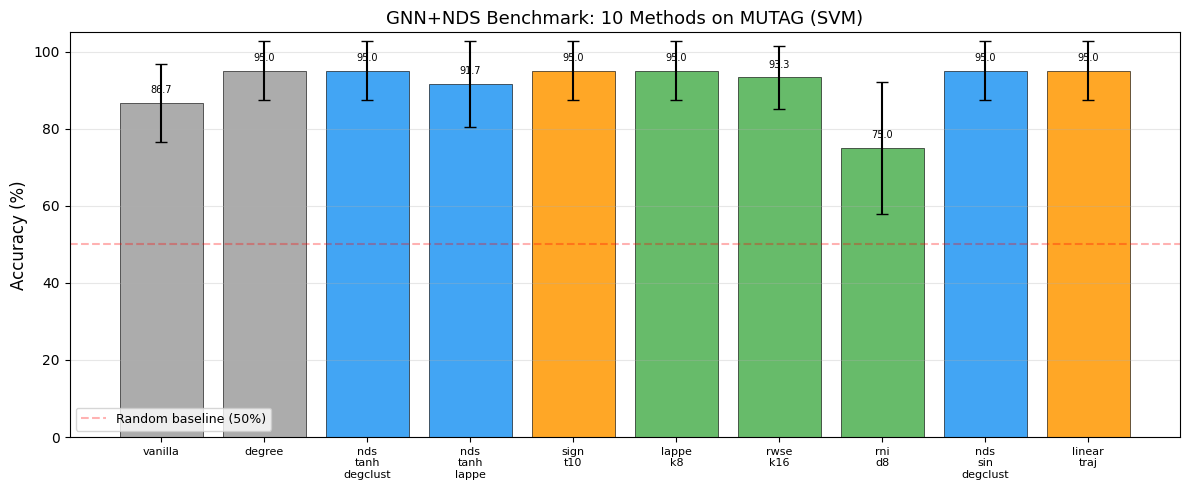

Plot saved to benchmark_results.png


In [12]:
# ── Summary Table ──────────────────────────────────────────────────────
print("=" * 60)
print("SUMMARY TABLE")
print("=" * 60)
print(f"\n{'Method':<25s} {'Accuracy':>12s} {'Preproc(s)':>12s}")
print("-" * 52)

methods_list = []
accs_list = []
stds_list = []

for ds_name in DATASET_NAMES:
    if ds_name not in all_results:
        continue
    for method_name in METHOD_NAMES:
        if method_name in all_results[ds_name]:
            r = all_results[ds_name][method_name]
            print(f"  {method_name:<25s} {r['mean_acc']:>6.1f}±{r['std_acc']:<4.1f} {r['preprocess_time']:>10.3f}")
            methods_list.append(method_name)
            accs_list.append(r['mean_acc'])
            stds_list.append(r['std_acc'])

# ── Verification Results ──────────────────────────────────────────────
print(f"\nRook/Shrikhande: Both 6-regular = {rook_result['rook_is_6_regular']}")
print(f"  deg+clust init: SIGN same = {rook_result['degclust_init']['sign_same']}")
print(f"  LapPE init: NDS differ = {rook_result['lappe_init']['nds_differ']} (L2={rook_result['lappe_init']['nds_l2']:.4f})")
print(f"SIGN == linear_traj: {sign_linear_check}")
if gin_mutag_result:
    print(f"GIN MUTAG validation (fold-0): {gin_mutag_result['mean_acc']:.1f}%")

# ── Bar Chart ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))

colors = []
for m in methods_list:
    if 'nds' in m:
        colors.append('#2196F3')  # Blue for NDS methods
    elif m in ('vanilla', 'degree'):
        colors.append('#9E9E9E')  # Gray for baselines
    elif m in ('sign_t10', 'linear_traj'):
        colors.append('#FF9800')  # Orange for linear methods
    else:
        colors.append('#4CAF50')  # Green for other augmentations

x_pos = np.arange(len(methods_list))
bars = ax.bar(x_pos, accs_list, yerr=stds_list, capsize=4,
              color=colors, edgecolor='black', linewidth=0.5, alpha=0.85)

ax.set_xticks(x_pos)
ax.set_xticklabels([m.replace('_', '\n') for m in methods_list],
                    fontsize=8, rotation=0)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('GNN+NDS Benchmark: 10 Methods on MUTAG (SVM)', fontsize=13)
ax.set_ylim(0, 105)
ax.axhline(y=50, color='red', linestyle='--', alpha=0.3, label='Random baseline (50%)')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accs_list):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
            f'{acc:.1f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig('benchmark_results.png', dpi=100, bbox_inches='tight')
plt.show()
print("Plot saved to benchmark_results.png")